# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
from __future__ import print_function


import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10Dir = 'cs231n/datasets/cifar-10-batches-py'
XTrain, yTrain, XTest, yTest = load_CIFAR10(cifar10Dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', XTrain.shape)
print('Training labels shape: ', yTrain.shape)
print('Test data shape: ', XTest.shape)
print('Test labels shape: ', yTest.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


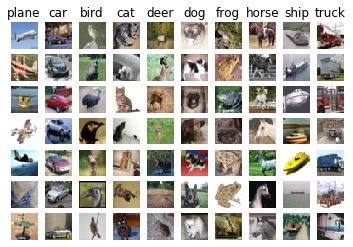

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
numClasses = len(classes)
samplesPerClass = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(yTrain == y)
    idxs = np.random.choice(idxs, samplesPerClass, replace = False)
    for i, idx in enumerate(idxs):
        pltIdx = i * numClasses + y + 1
        plt.subplot(samplesPerClass, numClasses, pltIdx)
        plt.imshow(XTrain[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
numTraining = 49000
numValidation = 1000
numTest = 1000
numDev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(numTraining, numTraining + numValidation)
XVal = XTrain[mask]
yVal = yTrain[mask]

# Our training set will be the first numTrain points from the original
# training set.
mask = range(numTraining)
XTrain = XTrain[mask]
yTrain = yTrain[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(numTraining, numDev, replace = False)
XDev = XTrain[mask]
yDev = yTrain[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(numTest)
XTest = XTest[mask]
yTest = yTest[mask]

print('Train data shape: ', XTrain.shape)
print('Train labels shape: ', yTrain.shape)
print('Validation data shape: ', XVal.shape)
print('Validation labels shape: ', yVal.shape)
print('Test data shape: ', XTest.shape)
print('Test labels shape: ', yTest.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
XTrain = np.reshape(XTrain, (XTrain.shape[0], -1))
XVal = np.reshape(XVal, (XVal.shape[0], -1))
XTest = np.reshape(XTest, (XTest.shape[0], -1))
XDev = np.reshape(XDev, (XDev.shape[0], -1))


# As a sanity check, print out the shapes of the data
print('Training data shape: ', XTrain.shape)
print('Validation data shape: ', XVal.shape)
print('Test data shape: ', XTest.shape)
print('dev data shape: ', XDev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


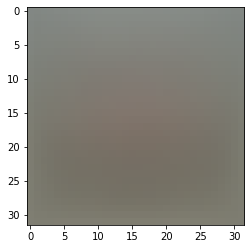

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
meanImage = np.mean(XTrain, axis = 0)
print(meanImage[ : 10]) # print a few of the elements
plt.figure(figsize = (4, 4))
plt.imshow(meanImage.reshape((32, 32, 3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
XTrain -= meanImage
XVal -= meanImage
XTest -= meanImage
XDev -= meanImage

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
XTrain = np.hstack([XTrain, np.ones((XTrain.shape[0], 1))])
XVal = np.hstack([XVal, np.ones((XVal.shape[0], 1))])
XTest = np.hstack([XTest, np.ones((XTest.shape[0], 1))])
XDev = np.hstack([XDev, np.ones((XDev.shape[0], 1))])

print(XTrain.shape, XVal.shape, XTest.shape, XDev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svmLossNaive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svmLossNaive(W, XDev, yDev, 0.00001)
print('loss: %f' % (loss, ))

loss: 8.719400


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [13]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svmLossNaive(W, XDev, yDev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svmLossNaive(w, XDev, yDev, 0.0)[0]
gradNumerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svmLossNaive(W, XDev, yDev, 1e2)
f = lambda w: svmLossNaive(w, XDev, yDev, 1e2)[0]
gradNumerical = grad_check_sparse(f, W, grad)

numerical: 0.887634 analytic: 0.887634, relative error: 2.104082e-10
numerical: -13.299546 analytic: -13.299546, relative error: 1.683890e-11
numerical: 5.389566 analytic: 5.413687, relative error: 2.232767e-03
numerical: -2.217129 analytic: -2.217129, relative error: 2.021470e-11
numerical: 21.114772 analytic: 21.114772, relative error: 9.768007e-12
numerical: -59.926879 analytic: -59.926879, relative error: 9.088081e-12
numerical: -15.244345 analytic: -15.244345, relative error: 2.636975e-12
numerical: 15.201076 analytic: 15.228204, relative error: 8.915141e-04
numerical: -4.650385 analytic: -4.650385, relative error: 2.761061e-11
numerical: -6.420519 analytic: -6.420519, relative error: 3.724259e-11
numerical: -4.312664 analytic: -4.306062, relative error: 7.659673e-04
numerical: -19.870717 analytic: -19.875416, relative error: 1.182281e-04
numerical: -0.281582 analytic: -0.286015, relative error: 7.810781e-03
numerical: 23.072733 analytic: 23.075435, relative error: 5.854789e-05
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [14]:
# Next implement the function svmLossVectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
lossNaive, gradNaive = svmLossNaive(W, XDev, yDev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (lossNaive, toc - tic))

from cs231n.classifiers.linear_svm import svmLossVectorized
tic = time.time()
lossVectorized, _ = svmLossVectorized(W, XDev, yDev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (lossVectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (lossNaive - lossVectorized))

Naive loss: 8.719400e+00 computed in 0.170352s
Vectorized loss: 8.719400e+00 computed in 0.010193s
difference: -0.000000


In [15]:
# Complete the implementation of svmLossVectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, gradNaive = svmLossNaive(W, XDev, yDev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, gradVectorized = svmLossVectorized(W, XDev, yDev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(gradNaive - gradVectorized, ord = 'fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.149230s
Vectorized loss and gradient: computed in 0.006884s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
lossHist = svm.train(XTrain, yTrain, learningRate = 1e-7, reg = 5e4,
                      numIters = 1500, verbose = True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 785.924908
iteration 100 / 1500: loss 107.289296
iteration 200 / 1500: loss 18.474281
iteration 300 / 1500: loss 7.410407
iteration 400 / 1500: loss 5.327069
iteration 500 / 1500: loss 4.909646
iteration 600 / 1500: loss 5.313808
iteration 700 / 1500: loss 4.992385
iteration 800 / 1500: loss 5.231692
iteration 900 / 1500: loss 5.096943
iteration 1000 / 1500: loss 5.060217
iteration 1100 / 1500: loss 5.249574
iteration 1200 / 1500: loss 5.600322
iteration 1300 / 1500: loss 5.644048
iteration 1400 / 1500: loss 5.529840
That took 9.913783s


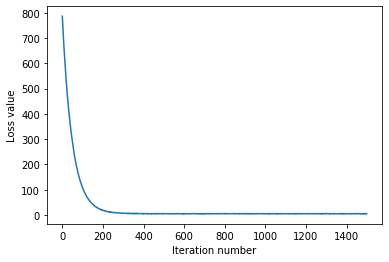

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(lossHist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
yTrainPred = svm.predict(XTrain)
print('training accuracy: %f' % (np.mean(yTrain == yTrainPred), ))
yValPred = svm.predict(XVal)
print('validation accuracy: %f' % (np.mean(yVal == yValPred), ))

training accuracy: 0.355102
validation accuracy: 0.361000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learningRates = [1e-8, 1e-7, 2e-7]
regularizationStrengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
bestVal = -1   # The highest validation accuracy that we have seen so far.
bestSvm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in bestVal and the LinearSVM object that achieves this   #
# accuracy in bestSvm.                                                         #
#                                                                              #
# Hint: You should use a small value for numIters as you develop your          #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for numIters.                                       #
################################################################################

## Initialising the SVM Classifier.
svm = LinearSVM()

for lr in learningRates:
    for reg in regularizationStrengths:
        
        ## Obtaining the loss history for the current hyperparameters.
        lossHist = svm.train(XTrain, yTrain, learningRate = lr, reg = reg, numIters = 1500)
        
        ## Performing predictions on the training set.
        yTrainPred = svm.predict(XTrain)
        
        ## Computing the training accuracy.
        accTrain = np.mean(yTrain == yTrainPred)
        
        ## Performing predictions on the validation set.
        yValPred = svm.predict(XVal)
        
        ## Computing the validation accuracy.
        accVal = np.mean(yVal == yValPred)
        
        ## Store the results in the dictionary.
        results[(lr, reg)] = (accTrain, accVal)
        
        if accVal > bestVal:
            bestVal = accVal
            bestSvm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    trainAccuracy, valAccuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, trainAccuracy, valAccuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % bestVal)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.246776 val accuracy: 0.239000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.345224 val accuracy: 0.335000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367000 val accuracy: 0.386000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.354163 val accuracy: 0.366000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.361347 val accuracy: 0.367000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.350449 val accuracy: 0.368000
best validation accuracy achieved during cross-validation: 0.386000


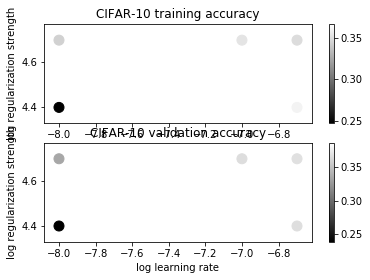

In [23]:
# Visualize the cross-validation results
import math
xScatter = [math.log10(x[0]) for x in results]
yScatter = [math.log10(x[1]) for x in results]

# plot training accuracy
markerSize = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(xScatter, yScatter, markerSize, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(xScatter, yScatter, markerSize, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [24]:
# Evaluate the best svm on test set
yTestPred = bestSvm.predict(XTest)
testAccuracy = np.mean(yTest == yTestPred)
print('linear SVM on raw pixels final test set accuracy: %f' % testAccuracy)

linear SVM on raw pixels final test set accuracy: 0.348000


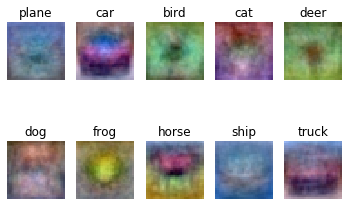

In [26]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = bestSvm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
wMin, wMax = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - wMin) / (wMax - wMin)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*